In [2]:
import numpy as np
import h5py as h5

import matplotlib.pyplot as plt

In [3]:
#h5f = '/home3/ivkhar/TA/data/MC/bundled/pr_q3_14yr_1745_0010_excl_sat_T_excl_geo_T_bundled.h5'
h5f = '/home3/ivkhar/TA/data/MC/bundled/onefile_bundled.h5'

In [4]:
num = 64

with h5.File(h5f,'r') as hf:
    times_flat = hf['dt_bunlde'][:num,:,:,4:5].astype(np.float64) # in mks
    times_diff = hf['dt_bunlde'][:num,:,:,5:6].astype(np.float64) # in mks
    mask_in = hf['dt_bunlde'][:num,:,:,6:7].astype(np.float64)
    real_coords = hf['dt_bunlde'][:num,:,:,:3].astype(np.float64)*1.2 # in km
    qs_in = hf['dt_bunlde'][:num,:,:,3:4].astype(np.float64)
    ev_params = hf['recos'][:num,[0,1,2,6]].astype(np.float64) # theta, phi, S_800, a_linsley
    
mask_qs = np.where( np.logical_and(mask_in>0, qs_in>0), 1., 0. )

In [5]:
# set c=1, time in mks, distance in km
time2dist = np.array([0.299792458], dtype=np.float64)

times_flat *= time2dist
times_diff *= time2dist

times_reg = times_flat + times_diff

In [6]:
theta_rub = ev_params[:num,0]/180*3.1415
phi_rub = ev_params[:num,1]/180*3.1415

In [7]:
# "-" in nz seems to be correct, by comparison
nx = - np.sin(theta_rub)[:,np.newaxis,np.newaxis] * np.cos(phi_rub)[:,np.newaxis,np.newaxis]
ny = - np.sin(theta_rub)[:,np.newaxis,np.newaxis] * np.sin(phi_rub)[:,np.newaxis,np.newaxis]
nz = - np.cos(theta_rub)[:,np.newaxis,np.newaxis]
a = np.concatenate((nx,ny,nz), axis=-1)
a = np.expand_dims( a, axis=1 )

t_rec_flat = np.sum( a*real_coords[:,:,:,:3], axis=-1 )
t_rec_flat = t_rec_flat*mask_in[:,:,:,0]

In [8]:
diff = np.abs(t_rec_flat - times_flat[:,:,:,0])
print(np.amax(diff))
print(diff[:3])

0.0002595419443122138
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.72306320e-04 6.05277709e-05
   9.43764583e-05 0.00000000e+00]
  [0.00000000e+00 2.53282639e-05 4.87298996e-05 8.09748287e-05
   4.58433711e-05 0.00000000e+00]
  [0.00000000e+00 1.75749145e-05 1.06736349e-04 2.58228467e-05
   0.00000000e+00 1.59748577e-05]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.38087154e-05
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 1.75111736e-04 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 1.16343158e-05 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 5.55982087e-05 2.10414645e-06 5.27256733e-05
   5.85009662e-06 0.00000000e+00]
  [9.48039518e-05 7.34003233e-05 3.82021915e-05 1.20694225e-04
   1.98365456e-04 0.00000000e+00]
  [0.0

In [9]:
a_rub = ev_params[:,3,np.newaxis,np.newaxis]
s_800_rub = ev_params[:,2,np.newaxis,np.newaxis]

theta_rub = ev_params[:num,0,np.newaxis,np.newaxis]/180*3.1415
phi_rub = ev_params[:num,1,np.newaxis,np.newaxis]/180*3.1415

In [10]:
def get_eta(theta):
    
    x = theta*180.0/3.1415
    
    e1 = 3.97 - 1.79*(np.abs(1.0/(np.abs(np.cos(theta))+1e-6)) - 1.0)
    e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
               + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
             + 3.70692527e+00)
    res = np.where(x<62.7,e1,e2)  
    
    return res

In [11]:
Rm = np.array([0.09])
R1 = np.array([1.])

def get_profile(r, eta):

    res = np.power(((r+1e-6)/Rm),-1.2) * np.power((1+r/Rm), -(eta-1.2)) * np.power(1.+r*r/R1/R1,-0.6)
    return res

In [12]:
# depending on def of a (linsley, prime), may or may not include S_800
# check fo 0.67
def get_lins_t(r):
    return 0.67*np.power((1 + r/R_L), 1.5)

In [13]:
# check dimensions in error calc
t0_err = 0.03*time2dist

def get_linsley_s(r, S):
    return 1.3*0.29*np.power((1 + r/R_L), 1.5)*np.power(S+1e-8, -0.3)

In [33]:
R_800 = np.array([0.8])
R_L = 0.03

# "-" in projection
def get_exp_time(theta, phi, coords, t_flat, aprime, mask, S_800):
    # get distance to shower core
    proj_to_n = np.sin(theta)*( np.cos(phi)*coords[:,:,:,0] + np.sin(phi)*coords[:,:,:,1] ) + np.cos(theta)*coords[:,:,:,2]
    dist_core = np.sum( np.power(coords,2), axis=(3) ) - np.power(proj_to_n,2)
    dist_core = np.where( dist_core>0, np.sqrt( dist_core ), 0. )
    # get eta
    eta = get_eta(theta)
    # eval time
    t_rec_curv = aprime*get_lins_t(dist_core)*np.sqrt( get_profile(R_800, eta)/get_profile(dist_core, eta) )*1e-3*time2dist
    # get error
    s_r = get_profile(dist_core, eta)
    s_8 = get_profile(0.8, eta)
    lin_s = get_linsley_s(dist_core, S_800*s_r/s_8 )
#     print('lin_s',lin_s)
    t_s = aprime*np.sqrt(S_800)*lin_s*1e-3*time2dist
#     print('ts',t_s)
    return t_rec_curv*mask, np.sqrt((t0_err*t0_err + t_s*t_s))*mask

In [34]:
t_rec_curv, t_err = get_exp_time(theta_rub, phi_rub, real_coords, t_rec_flat, a_rub, mask_qs[...,0], s_800_rub)

In [16]:
print(t_rec_curv[:5]-times_diff[:5,:,:,0])

[[[ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.00175419 -0.06258692 -0.64202004
    0.        ]
  [ 0.         -0.04859552 -0.09313132 -0.09177283 -0.01393131
    0.        ]
  [ 0.         -0.07133434 -0.10665879 -0.06957046  0.
   -0.41060827]
  [ 0.          0.          0.          0.05251522  0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0.          0.          0.73343437  0.          0.
    0.        ]
  [ 0.          0.         -0.06410294  0.          0.
    0.        ]
  [ 0.         -0.1919336  -0.09465956 -0.10246577 -0.52278469
    0.        ]
  [ 0.24612006 -0.1384063  -0.08296652 -0.07535847 -0.35882364
    0.        ]
  [ 0.         -0.49503326  0.         -0.0807551   0.
    1.46376517]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.         -0.31264704 -0.0978152   0

In [17]:
print(t_err[:5])

[[[0.         0.         0.         0.         0.         0.        ]
  [0.         0.         0.19522753 0.18752537 0.4247397  0.        ]
  [0.         0.18687465 0.02160456 0.01918694 0.17357822 0.        ]
  [0.         0.19998236 0.0271015  0.05540465 0.         0.75068378]
  [0.         0.         0.         0.23394275 0.         0.        ]
  [0.         0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.58574806 0.         0.         0.        ]
  [0.         0.         0.11828669 0.         0.         0.        ]
  [0.         0.09285005 0.01367434 0.0237159  0.19708444 0.        ]
  [0.38064065 0.07660034 0.00987144 0.02310187 0.18106529 0.        ]
  [0.         0.19426676 0.         0.12189164 0.         0.92485357]
  [0.         0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.         0.        ]
  [0.         0.25179612 0.0922333  0.16818421 0.         0.        ]
  [0.         0.

In [18]:
# get distance to shower core
proj_to_n = np.sin(theta_rub)*( np.cos(phi_rub)*real_coords[:,:,:,0] + np.sin(phi_rub)*real_coords[:,:,:,1] ) + np.cos(theta_rub)*real_coords[:,:,:,2]
dist_core = np.sum( np.power(real_coords,2), axis=(3) ) - np.power(proj_to_n,2)
dist_core = np.where( dist_core>0, np.sqrt( dist_core ), 0. )

In [19]:
dist_core.shape

(64, 6, 6)

### Raw, similar to R.

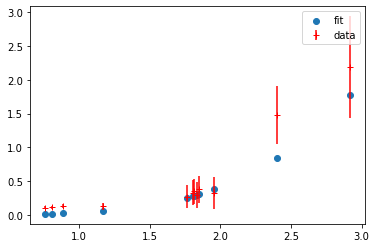

In [20]:
n_ev = 0

mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev])[mask]
ts = times_diff[n_ev][mask][:,0]
errs = t_err[n_ev][mask]

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask], ts, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask], ys, label='fit')
plt.legend()
plt.show()

In [27]:
times_diff[0,:,:,0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.29559536, 0.34446155, 1.47707745,
        0.        ],
       [0.        , 0.32917213, 0.10762549, 0.10372819, 0.26831424,
        0.        ],
       [0.        , 0.37833807, 0.127112  , 0.12501345, 0.        ,
        2.19178262],
       [0.        , 0.        , 0.        , 0.3255746 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [28]:
print(times_diff[n_ev][mask])
print(errs)
print(ys)

[[0.29559536]
 [0.34446155]
 [1.47707745]
 [0.32917213]
 [0.10762549]
 [0.10372819]
 [0.26831424]
 [0.37833807]
 [0.127112  ]
 [0.12501345]
 [2.19178262]
 [0.3255746 ]]
[0.19522753 0.18752537 0.4247397  0.18687465 0.02160456 0.01918694
 0.17357822 0.19998236 0.0271015  0.05540465 0.75068378 0.23394275]
[0.29734955 0.28187463 0.83505741 0.28057661 0.01449417 0.01195536
 0.25438294 0.30700373 0.02045321 0.055443   1.78117435 0.37808982]


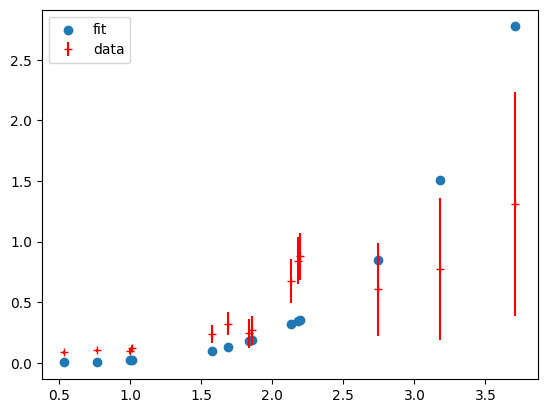

In [19]:
n_ev = 1

mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev])[mask]
ts = times_diff[n_ev][mask][:,0]
errs = t_err[n_ev][mask]

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask], ts, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask], ys, label='fit')
plt.legend()
plt.show()

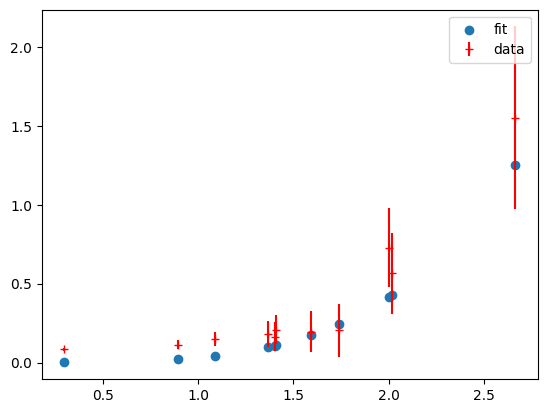

In [20]:
n_ev = 2

mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev])[mask]
ts = times_diff[n_ev][mask][:,0]
errs = t_err[n_ev][mask]

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask], ts, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask], ys, label='fit')
plt.legend()
plt.show()

### Normilize to 0 - eliminate constant

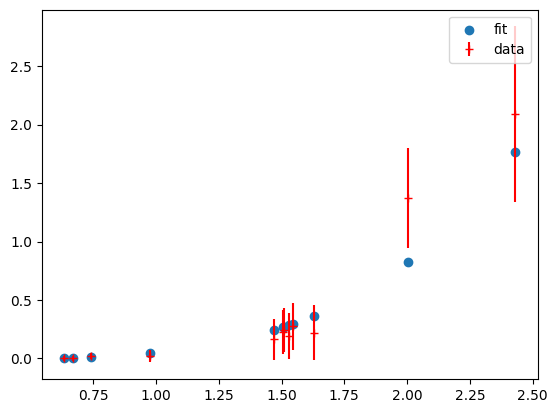

In [27]:
n_ev = 0

mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev])[mask]
ts = times_diff[n_ev][mask][:,0]
errs = t_err[n_ev][mask]

m = np.amin(ts)
ts += - m
m = np.amin(ys)
ys += - m

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask]/1.2, ts, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask]/1.2, ys, label='fit')
plt.legend()
plt.show()

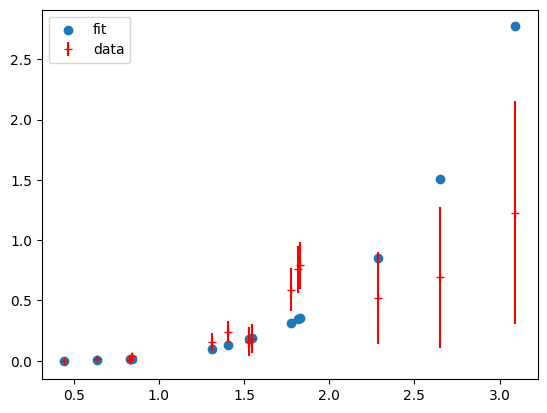

In [21]:
n_ev = 1

mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev])[mask]
ts = times_diff[n_ev][mask][:,0]
errs = t_err[n_ev][mask]

m = np.amin(ts)
ts += - m
m = np.amin(ys)
ys += - m

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask]/1.2, ts, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask]/1.2, ys, label='fit')
plt.legend()
plt.show()

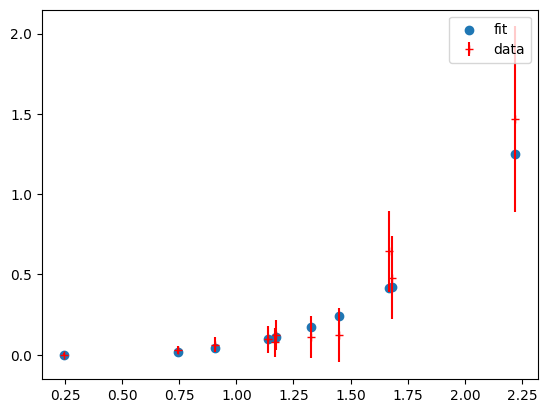

In [22]:
n_ev = 2

mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev])[mask]
ts = times_diff[n_ev][mask][:,0]
errs = t_err[n_ev][mask]

m = np.amin(ts)
ts += - m
m = np.amin(ys)
ys += - m

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask]/1.2, ts, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask]/1.2, ys, label='fit')
plt.legend()
plt.show()

### minus t earliest

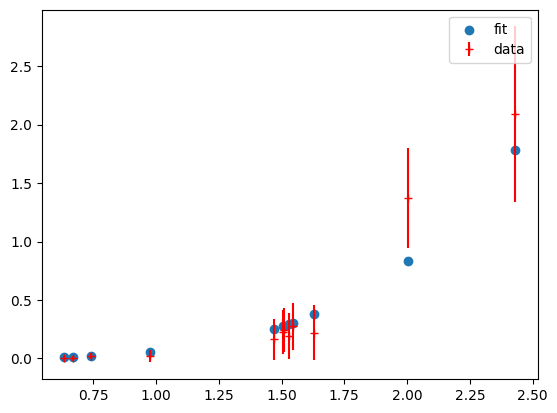

In [26]:
n_ev = 0

mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev])[mask]
ts = times_diff[n_ev][mask][:,0]
errs = t_err[n_ev][mask]

m = np.amin(ts)
ts += - m
# m = np.amin(ys)
# ys += - m

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask]/1.2, ts, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask]/1.2, ys, label='fit')
plt.legend()
plt.show()

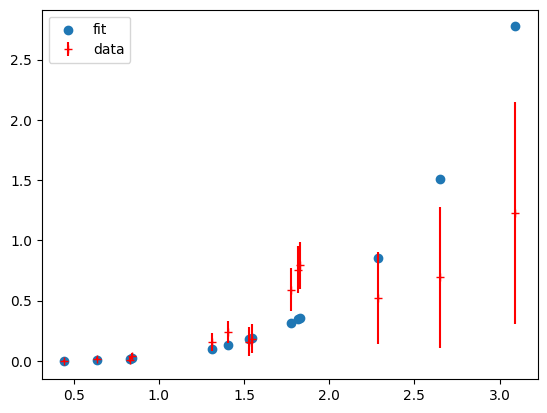

In [23]:
n_ev = 1

mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev])[mask]
ts = times_diff[n_ev][mask][:,0]
errs = t_err[n_ev][mask]

m = np.amin(ts)
ts += - m
# m = np.amin(ys)
# ys += - m

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask]/1.2, ts, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask]/1.2, ys, label='fit')
plt.legend()
plt.show()

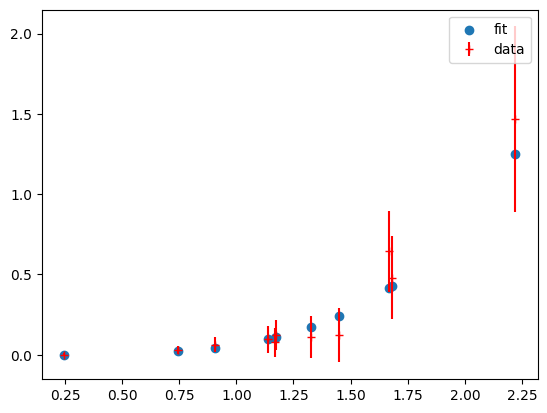

In [24]:
n_ev = 2

mask = mask_qs[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power( real_coords[n_ev][mask], 2), axis=-1) )
ys = (t_rec_curv[n_ev])[mask]
ts = times_diff[n_ev][mask][:,0]
errs = t_err[n_ev][mask]

m = np.amin(ts)
ts += - m
# m = np.amin(ys)
# ys += - m

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask]/1.2, ts, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask]/1.2, ys, label='fit')
plt.legend()
plt.show()